# Style transfer for generation of realistically textured subsurface models. Visualized and explained. 

*[Ovcharenko, Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://github.com/vkazei), [Daniel Peter](https://github.com/danielpeter), and [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home). ["Style transfer for generation of realistically textured subsurface models."](https://library.seg.org/doi/abs/10.1190/segam2019-3216349.1) In SEG Technical Program Expanded Abstracts 2019, pp. 2393-2397. Society of Exploration Geophysicists, 2019.*


This notebook reproduces workflow for **texture-transfer from an elastic isotropic subsurface model to a prior synthetic distribution**. We follow [(Gatys et al., 2015)](https://arxiv.org/abs/1508.06576) to transfer texture from a [Marmousi II](https://library.seg.org/doi/full/10.1190/1.2172306) benchmark geological model to a background distribution generated using a random Gaussian field.

We apply the iterative optimization approach which benefits from higher control at cost of longer generation times. To accelerate the texture transfer one would use a GAN-based approach as proposed by [(Johnson et al., 2016)](https://link.springer.com/chapter/10.1007/978-3-319-46475-6_43) and [(Ulyanov et al., 2016)](http://proceedings.mlr.press/v48/ulyanov16.pdf).


<hr>

Resources used:

https://github.com/kevinzakka/style-transfer

https://github.com/rrmina/neural-style-pytorch

https://www.tensorflow.org/beta/tutorials/generative/style_transfer

<hr>

In [1]:
import time
import numpy as np
from PIL import Image

import keras
from keras import backend as K
from keras.applications import vgg16
from scipy.optimize import fmin_l_bfgs_b

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('image', cmap='RdBu_r')
%matplotlib inline

np.random.seed(123)

Using TensorFlow backend.


### Helpers

In [2]:
def imshow_channels(img, clabels=True, title=None):
    subtitles_ = ('Vp', 'Vs', 'Rho'); clabels_ = ('m/s', 'm/s', 'g/cm3')
    fig = plt.figure()
    for ic in range(3):
        ax = fig.add_subplot(3, 1, ic + 1); im = ax.imshow(img[:, :, ic])
        ax.set_title(subtitles_[ic], rotation='vertical', x=-0.1, y=0.5)
        ax.axis('off'); cbar = fig.colorbar(im)
        cbar.set_label(clabels_[ic]) if clabels else None
        fig.suptitle(title) if title else None
    plt.pause(0.001)

def imshow_grid(data, nrows=8, ncols=2, pad=1):
    data = data[0, ...] if len(data.shape) > 3 else data
    h, w, c = data.shape
    h += pad; w += pad; k = 0
    grid = np.zeros((h * nrows + pad, w * ncols + pad))
    for irow in range(nrows):
        for icol in range(ncols):
            grid[1 + irow * h:(irow + 1) * h, 1 + icol * w:(icol + 1) * w] = data[:, :, k]
            k += 1
    plt.imshow(grid); plt.axis('off');

def imshow_grid3(data1, data2, data3):
    plt.subplot(1, 3, 1); imshow_grid(data1); plt.title('Content');
    plt.subplot(1, 3, 2); imshow_grid(data2); plt.title('Style')
    plt.subplot(1, 3, 3); imshow_grid(data3); plt.title('Target')
    plt.pause(0.001)

# Load data

The data we will be using are kept in NumPy format *.npy* suits well for storing multidimensional arrays. The **style (_s)** and **content (_c)** data contain one **[H x W x C]** tensor each, where H, W and C stand for depth, width and number of elastic isotropic parameters respectively. The last dimension **encodes compressional and share wave velocities (m/s), and density (g/cm3), Vp, Vs and Rho respectively**.

### Load style
The **style data are used as source of geological properties** and thus it has to have the realistic range similar to the range of desired output.

Style image: (141, 681, 3) [H x W x C]


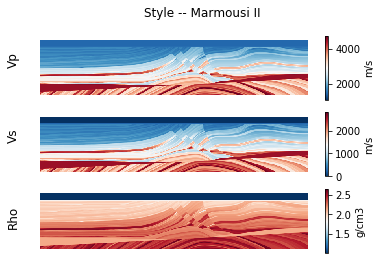

In [3]:
to_style = './data/marm.npy'

img_s = np.load(to_style)
print(f"Style image: {img_s.shape} [H x W x C]")
imshow_channels(img_s, clabels=True, title='Style -- Marmousi II')

### Load content
The **content data are used only as a source of relative contrasts and spatial distribution of objects in the target model**. Thus, its range might be arbitrary.

Content image: (100, 300, 3) [H x W x C]


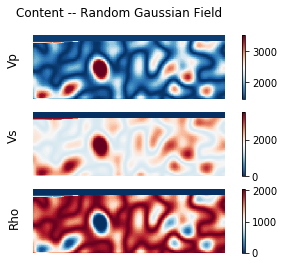

In [4]:
to_base = './data/gauss_field.npy'

img_c = np.load(to_base)
print(f"Content image: {img_c.shape} [H x W x C]")
imshow_channels(img_c, clabels=False, title='Content -- Random Gaussian Field')

# Preprocessing
The style-transfer has originally been proposed for colored RGB images, where values in each of color channels fall into the range of [0, 255]. First, we convert the data from geological to reference range and then fit it into the scale sutiable for the nural network.

### Scale from geological domain to [0, 1] range
We fit data from each channel of the input tensor [H x W x C] to the range [0,1] and **store the max and min values for each channel of style image only**. The content image is later scaled to fit the range of the style image.

In [5]:
class GeologyScaler(object):
    def __init__(self, img, lim=[0, 1]):
        vmax = np.array([img[:, :, i].max() for i in range(3)])
        vmin = np.array([img[:, :, i].min() for i in range(3)])

        self.vmax = vmax.reshape(1, 1, 3)
        self.vmin = vmin.reshape(1, 1, 3)
        self.lmin, self.lmax = lim

    # From geological scale to reference scale
    def g2r(self, img):
        return (img - self.vmin) * (self.lmax - self.lmin) / \
               (self.vmax - self.vmin) + self.lmin

    # From reference scale to geological scale
    def r2g(self, img):
        return (img - self.lmin) * (self.vmax - self.vmin) / \
               (self.lmax - self.lmin) + self.vmin

# Store the range of geological properties from style data
# and fit each channel into [0,1] range
scaler_geo = GeologyScaler(img_s)
img_s = scaler_geo.g2r(img_s)

# Fit each channel of the content data into [0,1] range
geo_c = GeologyScaler(img_c)
img_c = geo_c.g2r(img_c)

print(f"Style image max: {img_s.max()} min: {img_s.min()}")
print(f"Content image max: {img_c.max()} min: {img_c.min()}")

Style image max: 1.0 min: 0.0
Content image max: 1.0 min: 0.0


### Convert from [0, 1] to RGB [0, 255]

In [6]:
img_s *= 255.
img_c *= 255.

print(f"Style image max: {img_s.max()} min: {img_s.min()}")
print(f"Content image max: {img_c.max()} min: {img_c.min()}")

Style image max: 255.0 min: 0.0
Content image max: 255.0 min: 0.0


### Resize style image with respect to content image

Resize the style model to match size of the content model. Any other options would also work as soon as sized of style and content tensors are equal. **Generated image will have size of the content image**.

In [7]:
h, w, c = img_c.shape
new_dims = (h, w)

def resize(arr, dim):
    print(f"Resize {arr.shape} --> {dim + (3,)}")
    img = Image.fromarray(arr.astype(np.int8), mode='RGB')
    img = img.resize((dim[1], dim[0]))
    return np.array(img).astype(np.float32)

print("Style image. ", end="")
img_s = resize(img_s, new_dims)

Style image. Resize (141, 681, 3) --> (100, 300, 3)


### Scale with respect to ImageNet dataset
[ImgeNet](https://en.wikipedia.org/wiki/ImageNet) is a dataset designed for visual object recognition research. It contains more then 14M annotated images. The network used in our application was trained on this dataset, so we make sure that our data is mean-centered similarly.

In [8]:
class ImagenetScaler(object):
    def __init__(self):
        mean = np.array([103.939, 116.779, 123.68])
        self.mean = mean.reshape(1, 1, 3)

    # From RGB [0, 255] to ImageNet scale
    def r2i(self, img):
        img = img[:, :, ::-1]
        return img - self.mean

    # From ImageNet scale to [0, 255]
    def i2r(self, img):
        img += self.mean
        img = img[:, :, ::-1]
        return np.clip(img, 0, 255).astype('float32')

scaler_imnet = ImagenetScaler()
img_c = scaler_imnet.r2i(img_c)
img_s = scaler_imnet.r2i(img_s)

print(f"Style image max: {img_s.max()} min: {img_s.min()}")
print(f"Content image max: {img_c.max()} min: {img_c.min()}")

Style image max: 150.061 min: -123.68
Content image max: 151.061 min: -123.68


# Keras variables
[Keras](https://www.tensorflow.org/guide/keras) is a high-level library which simplifies running machine learning experiments. Under the hood, it builds a static computational graph which is faster to execute when compiled however sacrificing the easy-accessibility of intermediate steps.

Init Keras variables, names of Keras variables a followed by a trailing underscore "_"

In [9]:
img_s_ = K.variable(np.expand_dims(img_s, 0))
img_c_ = K.variable(np.expand_dims(img_c, 0))

print("Style image: {} [B x H x W x C]".format(K.int_shape(img_s_)))
print("Content image: {}".format(K.int_shape(img_c_)))

Style image: (1, 100, 300, 3) [B x H x W x C]
Content image: (1, 100, 300, 3)


Input to the network is a mini-batch of style and content images, together with a placeholder for the output. Each image in the batch is processed independently while running only one execution of the graph. Here, we also initialize the random noise starting point for optimization.

In [10]:
target = np.random.uniform(0, 255, (1, h, w, 3)) - 128.

img_out_ = K.variable(target)
img_in_= K.concatenate([img_c_, img_s_, img_out_], axis=0)

print("Input to VGG:\t\t{}".format(K.int_shape(img_in_)))
print("Output from VGG:\t{}".format(K.int_shape(img_out_)))

Input to VGG:		(3, 100, 300, 3)
Output from VGG:	(1, 100, 300, 3)


# Feature extractor
The key idea in Gatys et al., 2015 is that **layers of a neural network produce multi-scale representations of the input data**. Fine scale features might be extracted from shallow layers whereas generalized representations are encoded at deeper layers. Following the original paper we use outputs from the same convolutional layers as descriptors of style and content in the image.

The VGG16 network [(Simonyan and Zisserman, 2014)](https://arxiv.org/abs/1409.1556) has a relatively simple architecture. It is built as a stack of convolutional layers arranged into four blocks. The image below schematically shows the feature extractor of the original network. Red and blue colors highlight the style and content layers respectively.

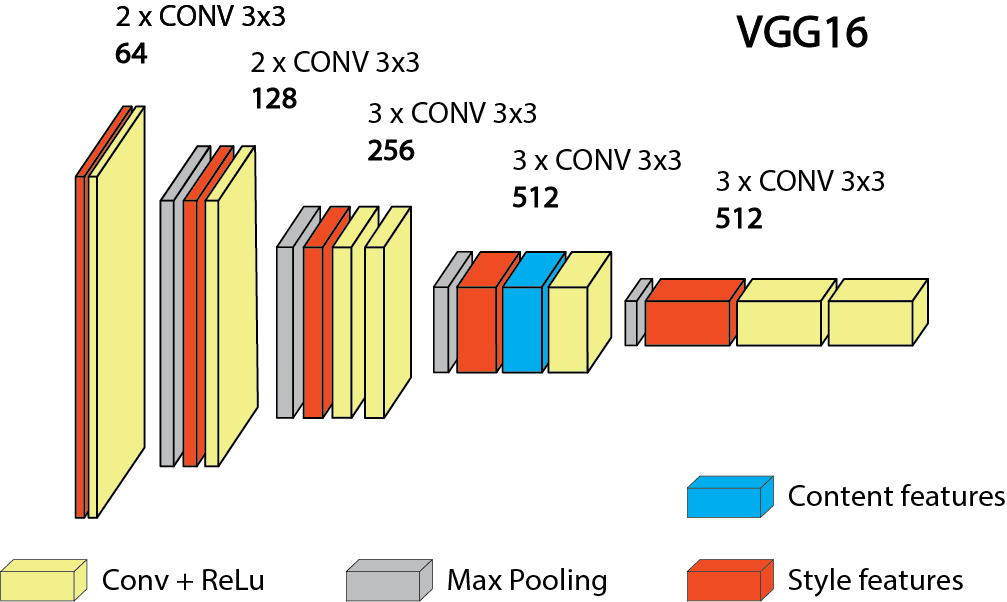

In [11]:
vgg = vgg16.VGG16(input_tensor=img_in_,
                  weights='imagenet',
                  include_top=False)
vgg.summary()

# Blue
layers_content = 'block4_conv2'
# Red
layers_style = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
                ]
# Dict, {"block1_conv1" : <output tensor>, ...}
fmap_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

# Understanding features
The pre-trained weights of VGG16 encode patterns which the network learned from the ImageNet dataset. We **visualize some kernels** to demonstrate that it is hardly possible to identify certain features by looking at kernels themselves. **Feature maps** produced by convolution of input volume to the layer with respective kernels deliver more meaningful information. We also demonstrate the correlation matrix, or **Gram matrix**, for kernels within the same layer which is the key component for building the texture representation of an image.

### Kernels
Also known as **filters**, are the weights which are convolved with the input data to produce a feature map. Spatial dimensions of all kernels in the VGG16 network are 3x3 whereas the depth of kernels varies for each convolutional layer and is always equal to the depth of the input volume to the layer. We compute the correlation matrix between kernels in the layer as well as verify the linear independence of kernels.

block2_conv1
	Kernels:	(3, 3, 64, 128)
	Correlation matrix:	(128, 128)	Rank:	128


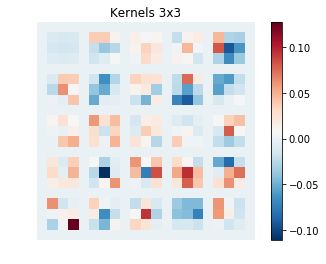

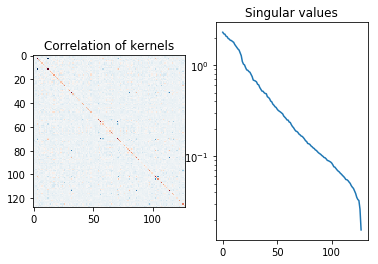

In [12]:
def show_kernels(model, layer, img):
    w = model.get_layer(layer).get_weights()[0]
    height, width, c, n = w.shape
    print(f'{layer}\n\tKernels:\t{w.shape}')
    wr = np.reshape(w, (-1, n))
    u, s, v = np.linalg.svd(wr)    
    g = np.matmul(wr.T, wr)
    print(f'\tCorrelation matrix:\t{g.shape}\tRank:\t{np.linalg.matrix_rank(g)}')
    
    plt.figure();imshow_grid(w[:,:,0,:], nrows=5, ncols=5); plt.colorbar();
    plt.title('Kernels 3x3');
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(g); plt.title(f'Correlation of kernels'); 
    plt.subplot(1,2,2)
    plt.semilogy(s); plt.title(f'Singular values'); 
    plt.show(); plt.close('all')
    
show_kernels(vgg, layers_style[1], img_in_)

### Content features
General features extracted from the deeper part of the network

block4_conv2
	In: (3, 100, 300, 3) -- > Out: (3, 12, 37, 512)


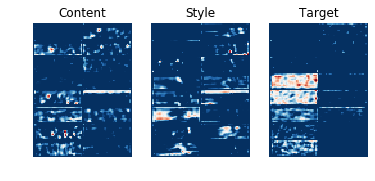

In [13]:
def show_feature_maps(model, layer, img):
    # Build a sub-graph which begins at the same point as vgg16 but ends at the given layer
    model = keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    p = model.predict(img, steps=1)
    print(f"{layer}\n\tIn: {img.shape} -- > Out: {p.shape}")
    imshow_grid3(p[0, ...], p[1, ...], p[2, ...]); plt.show()

# Feature maps for the content layer 'block4_conv2'
show_feature_maps(vgg, layers_content, img_in_)

### Style features
Detailed and general features extracted from all parts of the network. All together these build a texture representation of the input data.

block1_conv1
	In: (3, 100, 300, 3) -- > Out: (3, 100, 300, 64)


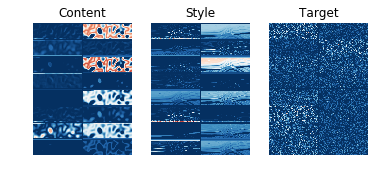

block4_conv1
	In: (3, 100, 300, 3) -- > Out: (3, 12, 37, 512)


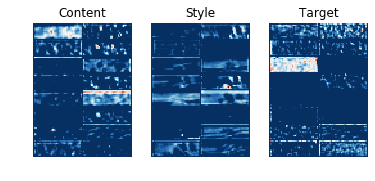

In [14]:
# Feature maps for several style layers 'blockN_conv1'
for layer in layers_style[::3]:
    show_feature_maps(vgg, layer, img_in_)

### Gram matrix
The correlation matrix between feature maps in a convolutional layer. The Gram matrix is later used in the style loss when measuring the texture similarity between images.

block2_conv1
	Out:	(3, 50, 150, 128)
	Gram:	(128, 128)	Rank:	121


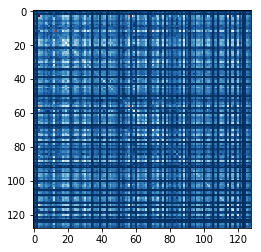

In [15]:
def show_gram(model, layer, img):
    model = keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    p = model.predict(img, steps=1)
    print(f"{layer}\n\tOut:\t{p.shape}")
    p = p[1,...] # 1 to get feature maps for style image
    h, w, c = p.shape
    p = p.reshape(h*w, c)
    g= np.matmul(p.T, p)
    print(f'\tGram:\t{g.shape}\tRank:\t{np.linalg.matrix_rank(g)}')
    plt.figure(); plt.imshow(g); plt.pause(0.001);
    del model, p
    
show_gram(vgg, layers_style[1], img_in_)

# Objective function
The goal of neural style-transfer is to **minimize the difference between feature representations of input image and respective style and content priors**. Thus the objective function consists of terms matching the similarity in content (**content loss**) and style (**style loss**) representations as well as a smoothing term (**total variation loss**). An optional constraint is to make the generated image match a certain vertical profiles from the style model (**well-log constraints**).

Contribution of each term in the objective function is defined by respective weight. Selection of weights controls properties of the generated output image and thus it is a user-guided task.

In [16]:
weight_content = 25
weight_style = 5e1
weight_tv = 1e4
weight_log = 5e4
iterations = 50

# Well-logs, a.k.a. vertical profiles
locations = [50, 150, 200]
well_logs = img_s[:, locations, :]
well_logs_ = K.variable(well_logs.copy())
print("Constrained well-logs: {}".format(K.int_shape(well_logs_)))

Constrained well-logs: (100, 3, 3)


### Style Loss
**Measures L2 distance between Gram matrices** extracted from selected style-descriptive layers  for genereted and style images.

In [17]:
def gram_matrix(f1):
    f1 = K.permute_dimensions(f1, (2, 0, 1))
    x = K.batch_flatten(f1)
    return K.dot(x, K.transpose(x))

# def gram_matrix(f1):
#     x = K.batch_flatten(f1)
#     return K.dot(K.transpose(x), x)

def style_loss(f1, f2):
    gram_f1 = gram_matrix(f1)
    gram_f2 = gram_matrix(f2)
    return K.sum(K.square(gram_f2 - gram_f1))

_loss_s = K.variable(0.0)
_weight_s = 1.0 / float(len(layers_style))

for layer in layers_style:
    fmap_s = fmap_dict[layer]
    f_style_s = fmap_s[1, :, :, :] # No 1 in batch -> style image
    f_out_s = fmap_s[2, :, :, :] # No 2 in batch -> target image
    _loss_s += _weight_s * style_loss(f_style_s, f_out_s) / float((2 * h * w * 3) ** 2)

loss_s = weight_style * _loss_s

### Content Loss
**Measures L2 distance between feature maps** extracted from the content-descriptive layer for the generated and content images.

In [18]:
def content_loss(f1, f2):
    return K.sum(K.square(f2 - f1))

fmap_c = fmap_dict[layers_content]
f_base_c = fmap_c[0, :, :, :]  # 0 in batch -> content image
f_out_c = fmap_c[2, :, :, :]  # 2 in batch -> target image
loss_c = weight_content * content_loss(f_base_c, f_out_c)

### Total variation loss
**A smoothing term** applied directly to the generated image. To enforce the fine layering we reduce smoothing along the vertical direction. This is not a canonical formulation of TV regularization, but we keep the name following the sources used while building this example. 

In [19]:
def tv_loss(img):
    b, h, w, c = img.shape.as_list()
    a = K.square(img[:, :h-1, :w-1, :] - img[:, 1:, :w-1, :])
    b = K.square(img[:, :h-1, :w-1, :] - img[:, :h-1, 1:, :])
    return K.sum(K.pow(a/2 + b, 1.25))

loss_tv = weight_tv * tv_loss(img_out_)

### Well-log constraint
**Measures L2 distance between selected well-logs** in the generated and style images.

In [20]:
def well_log_loss(img, idx, loc):
    log_out = img[0, :, loc, :]
    return K.sum(K.square(log_out - well_logs_[:, idx, :]))

_loss_log = K.variable(0.0)
_weight_log = 1.0 / float(len(locations))
for idx, val in enumerate(locations):
    _loss_log += well_log_loss(img_out_, idx, val)

loss_log = weight_log * _loss_log

### Total Loss

In [21]:
loss_total = loss_c + loss_s + loss_tv + loss_log

# Gradients of target image with respect to the total loss
Keras builds a computational graph and thus keeps track of all operations applied to variables within the graph. This allows automatic computation of gradients with recpect to target parameters by using the chain rule and following the graph in the backward direction. 

In [22]:
grads = K.gradients(loss_total, img_out_)

Implementation of [L-BFGS](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html) algorithm requires loss and grad to be two separate functions. We create a Keras function that computes the loss and respective gradients and then split it in two. 

In [23]:
loss_and_grads = K.function([img_out_], [loss_total] + grads)

def loss(x):
    x = x.reshape((1, h, w, 3))
    return loss_and_grads([x])[0].flatten().astype('float64')

def grads(x):
    x = x.reshape((1, h, w, 3))
    return loss_and_grads([x])[1].flatten().astype('float64')

# Optimization
Initiated from random noise the iterative optimization searches for a distribution of parameters which would minimize the misfit between multiscale representaions of the target image, content and style models.

Iter 1/50:
	Loss: 1.93e+12, Time: 2.32 seconds


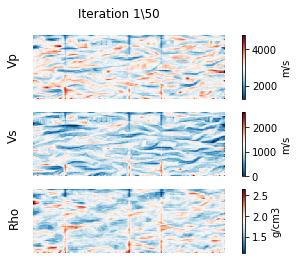

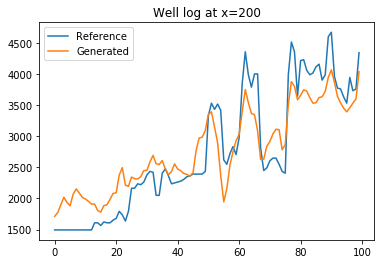

Iter 2/50:
	Loss: 1.16e+12, Time: 1.06 seconds
Iter 3/50:
	Loss: 9.52e+11, Time: 1.12 seconds
Iter 4/50:
	Loss: 8.28e+11, Time: 1.10 seconds
Iter 5/50:
	Loss: 7.57e+11, Time: 1.09 seconds
Iter 6/50:
	Loss: 7.19e+11, Time: 1.05 seconds
Iter 7/50:
	Loss: 6.96e+11, Time: 1.02 seconds
Iter 8/50:
	Loss: 6.80e+11, Time: 1.09 seconds
Iter 9/50:
	Loss: 6.67e+11, Time: 1.03 seconds
Iter 10/50:
	Loss: 6.57e+11, Time: 1.03 seconds
Iter 11/50:
	Loss: 6.50e+11, Time: 1.09 seconds
Iter 12/50:
	Loss: 6.44e+11, Time: 1.10 seconds
Iter 13/50:
	Loss: 6.39e+11, Time: 1.11 seconds
Iter 14/50:
	Loss: 6.35e+11, Time: 1.06 seconds
Iter 15/50:
	Loss: 6.31e+11, Time: 1.08 seconds
Iter 16/50:
	Loss: 6.28e+11, Time: 1.06 seconds
Iter 17/50:
	Loss: 6.25e+11, Time: 1.07 seconds
Iter 18/50:
	Loss: 6.22e+11, Time: 1.15 seconds
Iter 19/50:
	Loss: 6.20e+11, Time: 1.12 seconds
Iter 20/50:
	Loss: 6.18e+11, Time: 1.09 seconds
Iter 21/50:
	Loss: 6.16e+11, Time: 1.08 seconds
Iter 22/50:
	Loss: 6.15e+11, Time: 1.08 seconds


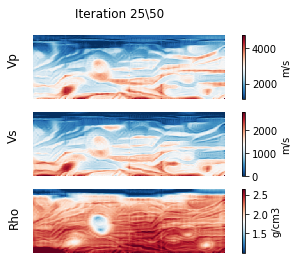

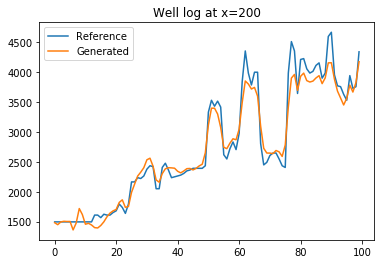

Iter 26/50:
	Loss: 6.10e+11, Time: 1.15 seconds
Iter 27/50:
	Loss: 6.09e+11, Time: 1.16 seconds
Iter 28/50:
	Loss: 6.08e+11, Time: 1.16 seconds
Iter 29/50:
	Loss: 6.07e+11, Time: 1.10 seconds
Iter 30/50:
	Loss: 6.07e+11, Time: 1.10 seconds
Iter 31/50:
	Loss: 6.06e+11, Time: 1.06 seconds
Iter 32/50:
	Loss: 6.05e+11, Time: 1.05 seconds
Iter 33/50:
	Loss: 6.05e+11, Time: 1.00 seconds
Iter 34/50:
	Loss: 6.04e+11, Time: 1.00 seconds
Iter 35/50:
	Loss: 6.04e+11, Time: 0.98 seconds
Iter 36/50:
	Loss: 6.03e+11, Time: 1.07 seconds
Iter 37/50:
	Loss: 6.03e+11, Time: 1.00 seconds
Iter 38/50:
	Loss: 6.02e+11, Time: 1.07 seconds
Iter 39/50:
	Loss: 6.02e+11, Time: 1.11 seconds
Iter 40/50:
	Loss: 6.02e+11, Time: 1.04 seconds
Iter 41/50:
	Loss: 6.01e+11, Time: 1.07 seconds
Iter 42/50:
	Loss: 6.01e+11, Time: 1.01 seconds
Iter 43/50:
	Loss: 6.01e+11, Time: 1.14 seconds
Iter 44/50:
	Loss: 6.00e+11, Time: 1.10 seconds
Iter 45/50:
	Loss: 6.00e+11, Time: 1.06 seconds
Iter 46/50:
	Loss: 6.00e+11, Time: 1.07 

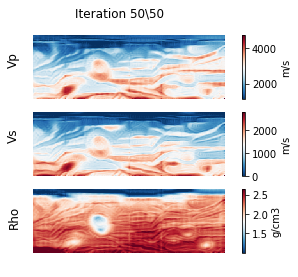

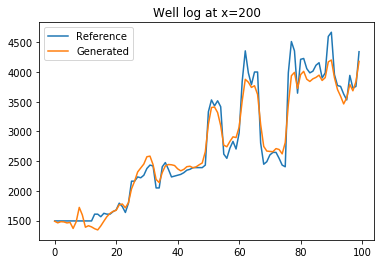

In [24]:
for i in range(iterations):
    print(f'Iter {i+1}/{iterations}:')
    toc = time.time()
    target, min_val, info = fmin_l_bfgs_b(loss, target.flatten(), fprime=grads, maxfun=20)
    tic = time.time()
    print('\tLoss: {:.2e}, Time: {:.2f} seconds'.format(float(min_val), float(tic - toc)))

    if (i+1) < 2 or (i+1) % 25 == 0:
        img = target.copy().reshape((h, w, 3))
        img = scaler_imnet.i2r(img) / 255.
        img = scaler_geo.r2g(img)
        
        plt.close('all'); imshow_channels(img, title=f'Iteration {i+1}\{iterations}')
        plt.figure(); plt.title(f'Well log at x={locations[-1]}')
        plt.plot(scaler_geo.r2g(scaler_imnet.i2r(well_logs.copy())/255.)[:,-1,0]); 
        plt.plot(img[:,locations[-1],0]); plt.legend(['Reference', 'Generated']); plt.pause(0.001)
        

# Summary

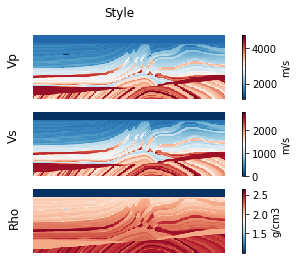

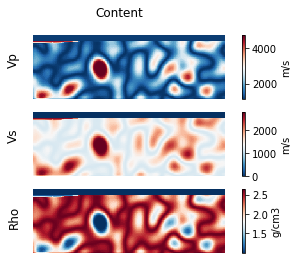

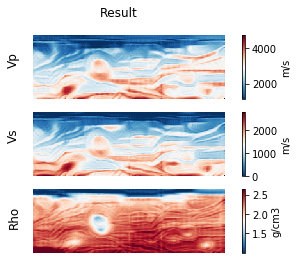

In [25]:
imshow_channels(scaler_geo.r2g(scaler_imnet.i2r(img_s)/255.), title='Style')
imshow_channels(scaler_geo.r2g(scaler_imnet.i2r(img_c)/255.),title='Content')
imshow_channels(img,title='Result')